In [11]:
# Imports
import torch
from torch import nn

from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from torchvision import datasets, transforms

import numpy as np

import matplotlib.pyplot as plt
from PIL import Image

In [12]:
# Device agnostic code
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Food Vision Mini
---
This is a small version of a food-classfication project which classifies an image as pizza, steak or sushi.

The data used for this project is from Food-101 dataset which contains 101 different food classes with 1000 images per class including both trianing and testing.

Our dataset contains only 3 different classes (pizza, steak, sushi) and only 10% of the images.

## Data Download

In [13]:
# Downloading the data -> pizza, steak, sushi
import requests
from pathlib import Path
import zipfile

data_path = Path('./data/')

# Check if the folder already exists
if data_path.is_dir():
    print(f"Data has already been downloaded.")
else:
    data_path.mkdir(parents=True, exist_ok=True)
    
    print("Downloading data...\n\n")
    
    with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
        request = requests.get('https://github.com/mrdbourke/pytorch-deep-learning/raw/refs/heads/main/data/pizza_steak_sushi.zip')
        f.write(request.content)
    
    with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
        zip_ref.extractall(data_path)
    
    print("Download successful.")

Data has already been downloaded.


## Data Preperation and Exploration

In [14]:
# Walkthrough the data folder
import os

def walk_through_dir(dir_path):
    """
    The function goes through all the directories and files of the given root directory.
    It prints the number of directories and files that are in a directory starting at the root until the deepest dir.
    
    Args:
        dir_path: A Path file which contains the path for the root directory.
        
    Returns:
        None
    """
    for dirpath, dirnames, filenames in os.walk(dir_path):
        print(f"There are {len(dirnames)} directories and {len(filenames)} in {dirpath}")

In [15]:
walk_through_dir(data_path)

There are 2 directories and 1 in data
There are 3 directories and 0 in data/test
There are 0 directories and 19 in data/test/steak
There are 0 directories and 25 in data/test/pizza
There are 0 directories and 31 in data/test/sushi
There are 3 directories and 0 in data/train
There are 0 directories and 75 in data/train/steak
There are 0 directories and 78 in data/train/pizza
There are 0 directories and 72 in data/train/sushi


### Data Class Summary

- Pizza: 78 Train / 25 Test

- Steak: 75 Train / 19 Test

- Sushi: 72 Train / 31 Test

## Random Visualization

In [ ]:
# Random data visualization
import random

# list of all the paths of the images in the data folder
image_paths = list(data_path.glob('*/*/*.jpg'))

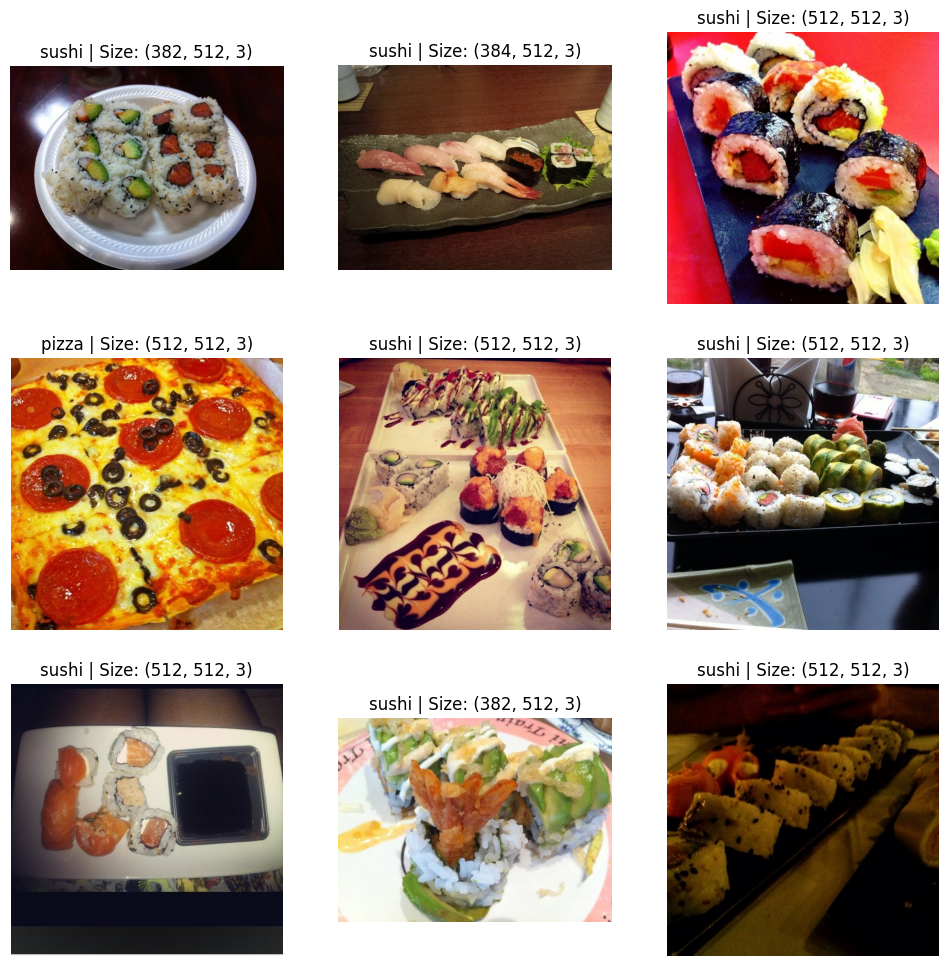

In [ ]:
# Random images using matplotlib
fig = plt.figure(figsize = (12, 12))
rows, cols = 3, 3

random_image_paths = random.choices(image_paths, k=rows*cols)

for i, path in enumerate(random_image_paths):
    img = Image.open(path)
    img = np.asarray(img)
    
    fig.add_subplot(rows, cols, i+1)
    
    plt.imshow(img)
    plt.title(f"{str(path.parent.stem)} | Size: {img.shape}")
    plt.axis(False)

## Transformations

In [ ]:
data_transform = transforms.Compose([
    # Resize
    transforms.Resize(size = (64, 64)),
    # Flip
    transforms.RandomHorizontalFlip(p = 0.5),   # probability = 50%
    # Image to tensor
    transforms.ToTensor(),
])

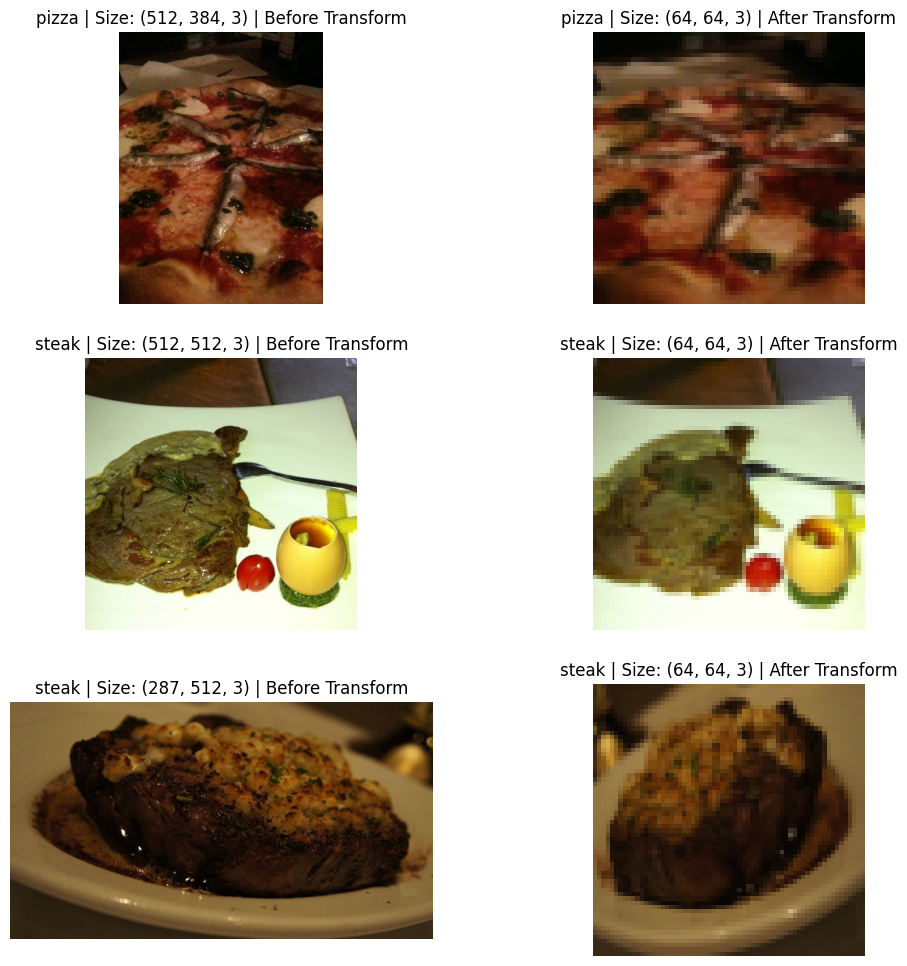

In [45]:
# Compare random images using matplotlib before and after transform
fig = plt.figure(figsize = (12, 12))
rows, cols = 3, 2
subplot_num = 0

random_image_paths = random.choices(image_paths, k=int((rows*cols)/2))

for i, path in enumerate(random_image_paths):
    img = Image.open(path)
    
    img_no_transform = np.asarray(img)
    img_transform = np.asarray(data_transform(img).permute(1,2,0))
    
    subplot_num += 1
    fig.add_subplot(rows, cols, subplot_num)
    plt.imshow(img_no_transform)
    plt.title(f"{str(path.parent.stem)} | Size: {img_no_transform.shape} | Before Transform")
    plt.axis(False)
    
    subplot_num += 1
    fig.add_subplot(rows, cols, subplot_num)
    plt.imshow(img_transform)
    plt.title(f"{str(path.parent.stem)} | Size: {img_transform.shape} | After Transform")
    plt.axis(False)
    
    

## Loading image data using ImageFolder

In [47]:
# Setting train and test directories
train_dir = data_path / 'train'
test_dir = data_path / 'test'

In [48]:
# Loading the datasets
train_data = datasets.ImageFolder(root=train_dir,
                                  transform=data_transform,
                                  target_transform=None)        # No transformation for labels

test_data = datasets.ImageFolder(root=test_dir,
                                 transform=data_transform,
                                 target_transform=None)

print(train_data)

Dataset ImageFolder
    Number of datapoints: 225
    Root location: data/train
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )


In [ ]:
# Loading datasets to dataloaders
batch_size = 16

train_dataloader = DataLoader(dataset=train_data,
                              batch_size=batch_size,
                              num_workers=4,
                              shuffle=True)

test_dataloader = DataLoader(dataset=test_data,
                             batch_size=batch_size * 2,
                             num_workers=4,
                             shuffle=True)

In [51]:
# Creating variables for class information
class_names = train_data.classes
class_names_dict = train_data.class_to_idx

print(class_names)
print()
print(class_names_dict)

['pizza', 'steak', 'sushi']

{'pizza': 0, 'steak': 1, 'sushi': 2}


### Data discrepency notes:

- Image shapes vary (Random image visualization)
    - Dealt with the issue using Resize() transform

- There are mismatches between pictures and labels. <br>
eg: A picture of a cup labeled as pizza, fries as pizza (Random image visualization)